# Experiment Data

### Todo
- Speed plots
- find max speed for continuity checks
- number of visits to arbitrary area

### problems
- undistort_point is not working with the reinforced location
- something looks off with the undistort_data of some sessions (see Test pv20_exp9_20210531_120417)

In [2]:
import os
import sys
import Kleinberg_burst_analysis
os.chdir('/home/tal/dev/reptilearn/system')
sys.path.append('/home/tal/dev/reptilearn/analysis')
import analysis
from pathlib import Path
import pandas as pd
import numpy as np
import undistort
import re
import cv2 as cv
import pprint as pp
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import visualize
import bbox
import moviepy.video.io.ffmpeg_tools as ff
import copy
import math
from tqdm.auto import tqdm
import json
import scipy.stats as stats

## Reload

In [7]:
importlib.reload(analysis)
importlib.reload(undistort)
importlib.reload(visualize)
importlib.reload(Kleinberg_burst_analysis)

<module 'Kleinberg_burst_analysis' from '/home/tal/dev/reptilearn/analysis/Kleinberg_burst_analysis.py'>

In [8]:
config = analysis.load_config("config")

In [9]:
pd.set_option('display.max_rows', 500)
all_sessions = analysis.list_sessions(config.session_data_root)
index = all_sessions.index
all_sessions = pd.concat([all_sessions.reset_index(drop=True), analysis.sessions_stats_df(all_sessions)], axis=1)
all_sessions.index = index

In [10]:
# n most recent experiments
n = 10
all_sessions.sort_index(ascending=False).head(n)

name  \
2021-08-18 14:16:09          climbing1_PV28   
2021-08-18 12:17:36          Climbing1_PV20   
2021-08-17 15:12:22             pv4_vstim_0   
2021-08-16 16:05:20              vid_test_2   
2021-08-16 16:03:01              bug_trial2   
2021-08-16 15:44:12              vid_trial1   
2021-08-16 15:33:31              bug_trial1   
2021-08-16 13:29:37     Nitz_heat_1608_PV28   
2021-08-16 11:35:46           pogona_hunter   
2021-08-15 13:36:22  Nitzan_heat4_1508_PV28   

                                                                   dir  \
2021-08-18 14:16:09  /data/reptilearn/experiments/climbing1_PV28_20...   
2021-08-18 12:17:36  /data/reptilearn/experiments/Climbing1_PV20_20...   
2021-08-17 15:12:22  /data/reptilearn/experiments/pv4_vstim_0_20210...   
2021-08-16 16:05:20  /data/reptilearn/experiments/vid_test_2_202108...   
2021-08-16 16:03:01  /data/reptilearn/experiments/bug_trial2_202108...   
2021-08-16 15:44:12  /data/reptilearn/experiments/vid_trial1_202108...   
2021-08-16 15:33:31  /data/reptilearn/experiments/bug_trial1_202108...   
2021-08-16 13:29:37  /data/reptilearn/experiments/Nitz_heat_1608_PV...   
2021-08-16 11:35:46  /data/reptilearn/experiments/pogona_hunter_202...   
2021-08-15 13:36:22  /data/reptilearn/experiments/Nitzan_heat4_1508...   

                     video_count  image_count  csv_count  
2021-08-18 14:16:09            4            1          6  
2021-08-18 12:17:36            4            1          6  
2021-08-17 15:12:22            4            0          5  
2021-08-16 16:05:20           44            0         46  
2021-08-16 16:03:01            0            0          1  
2021-08-16 15:44:12           36            0         38  
2021-08-16 15:33:31            4            0          5  
2021-08-16 13:29:37            4            1          6  
2021-08-16 11:35:46            0            0          1  
2021-08-15 13:36:22            4            1          6

In [11]:
exclude_list = []
sessions = all_sessions[all_sessions.name.str.startswith('pv20') & ~all_sessions.dir.isin(exclude_list)]

In [12]:
for ts, exp in sessions.iterrows(): print(exp.dir)

/data/reptilearn/experiments/pv20_exp3_20210519_103530
/data/reptilearn/experiments/pv20_exp3_20210519_120403
/data/reptilearn/experiments/pv20_exp3_20210519_125353
/data/reptilearn/experiments/pv20_exp3_20210519_133447
/data/reptilearn/experiments/pv20_exp4_20210520_112511
/data/reptilearn/experiments/pv20_exp6_20210524_092130
/data/reptilearn/experiments/pv20_exp6_20210524_114758
/data/reptilearn/experiments/pv20_exp7_20210527_111256
/data/reptilearn/experiments/pv20_exp6_2_20210527_134505
/data/reptilearn/experiments/pv20_exp8_20210531_101857
/data/reptilearn/experiments/pv20_exp9_20210531_120417
/data/reptilearn/experiments/pv20_exp10_bottom_left_20210602_110241
/data/reptilearn/experiments/pv20_exp10_20210607_102406
/data/reptilearn/experiments/pv20_exp11_20210610_105209
/data/reptilearn/experiments/pv20_exp11_20210614_110403
/data/reptilearn/experiments/pv20_long_20210630_114712
/data/reptilearn/experiments/pv20_morning_20210701_070140
/data/reptilearn/experiments/pv20_morning_ch

# Extract event subclips

In [400]:
def analyze_experiment(exp):
    print(f"Experiment: {exp.name} {exp.dir}")
    info = analysis.load_timestamps(analysis.experiment_info(exp.dir))
    events = analysis.read_event_log(info)
    top_vids_info = analysis.find_src_videos(info, "top")
    
    # Create analysis dir if not exists.
    analysis_dir = exp.dir / "analysis" / "event_clips"
    
    if analysis_dir.exists():
        return
    
    analysis_dir.mkdir(exist_ok=True, parents=True)
    
    # Reward events
    event = 'arena/dispense_reward'
    reward_video_event_df = analysis.create_video_event_df(top_vids_info, events.query("event == @event"))
    print(reward_video_event_df)
    analysis.extract_event_clips(reward_video_event_df, analysis_dir, file_prefix='reward')

    """    
    # old event types 
    old_events = {
        "in_area": events[events.event.str.startswith("learn_exp") & events.value.str.contains("in radius")],
        "out_of_area_wait": events[events.event.str.startswith("learn_exp") & events.value.str.contains("out of radius, waiting")],
        "out_of_area_end_trial": events[events.event.str.startswith("learn_exp") & events.value.str.contains("out of radius, ended")]
    }
    
    # new event types 
    new_events = {
        "in_area": events[events.event.str.contains("in_radius")],
        "out_of_area_wait": events[events.event.str.contains("out_radius")],
        "out_of_area_end_trial": events[events.event.str.contains("logical_trial_ended")]            
    }
    
    pre_secs, post_secs = 5, 5

    for event_list in [old_events, new_events]:
        for event_name, events in event_list.items():
            _ = analysis.extract_event_clips(
                analysis.create_video_event_df(top_vids_info, events), 
                analysis_dir, 
                file_prefix=event_name,
                pre_secs=pre_secs,
                post_secs=post_secs,    
            )
    """
    

In [402]:
for ts, exp in tqdm(sessions.iterrows(), total=len(sessions)):
    try:
        analyze_experiment(exp)
    except Exception as e:
        print(e)

  0%|          | 0/28 [00:00<?, ?it/s]

Experiment: 2021-05-19 10:35:30 /data/reptilearn/experiments/pv20_exp3_20210519_103530
Experiment: 2021-05-19 12:04:03 /data/reptilearn/experiments/pv20_exp3_20210519_120403
Experiment: 2021-05-19 12:53:53 /data/reptilearn/experiments/pv20_exp3_20210519_125353
Experiment: 2021-05-19 13:34:47 /data/reptilearn/experiments/pv20_exp3_20210519_133447
Experiment: 2021-05-20 11:25:11 /data/reptilearn/experiments/pv20_exp4_20210520_112511
Experiment: 2021-05-24 09:21:30 /data/reptilearn/experiments/pv20_exp6_20210524_092130
Experiment: 2021-05-24 11:47:58 /data/reptilearn/experiments/pv20_exp6_20210524_114758
Experiment: 2021-05-27 11:12:56 /data/reptilearn/experiments/pv20_exp7_20210527_111256
Experiment: 2021-05-27 13:45:05 /data/reptilearn/experiments/pv20_exp6_2_20210527_134505
Experiment: 2021-05-31 10:18:57 /data/reptilearn/experiments/pv20_exp8_20210531_101857
Experiment: 2021-05-31 12:04:17 /data/reptilearn/experiments/pv20_exp9_20210531_120417
Experiment: 2021-06-02 11:02:41 /data/rep

# Head Position

In [14]:
infos = []
for i, (ts, sess) in enumerate(tqdm(sessions.iterrows(), total=len(sessions))):
    info = analysis.session_info(sess.dir)
    infos.append(analysis.load_timestamps(info))

  0%|          | 0/29 [00:00<?, ?it/s]

In [13]:
info = analysis.session_info(sessions.iloc[-1].dir)
info = analysis.load_timestamps(info)

In [14]:
cent_dfs = []

for info in tqdm(infos):
    if "head_bbox" in info:
        centroids = analysis.get_head_centroids(info, None) # config.undistort_flir_blackfly_computar)
        cent_df = pd.DataFrame(centroids, columns=["x", "y"])
        cent_dfs.append(cent_df)

  0%|          | 0/29 [00:00<?, ?it/s]

In [15]:
mapping, roi, newcamtx = undistort.get_undistort_mapping(1440, 1080, config.undistort_flir_blackfly_computar)

backgrounds = []

for info in infos:
    imgs = [p for p in info["images"] if "reinforced_area" in p.name]
    if len(imgs) > 0:
        img = cv.imread(str(imgs[0]))
        backgrounds.append(img)        
        # backgrounds.append(undistort.undistort_image(img, mapping))
    else:
        backgrounds.append(None)

In [16]:
durations = []
for info in infos:
    cams = [list(vid.values())[0] for vid in info["videos"].values()]
    durations.append(sum([cam["duration"] for cam in cams]))

  0%|          | 0/29 [00:00<?, ?it/s]

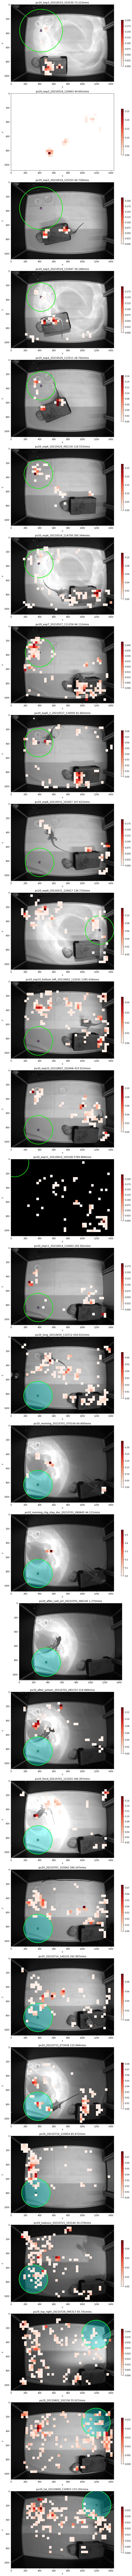

In [17]:
n = sessions.shape[0]
l = 1# math.ceil(math.sqrt(n))
sx = 10
sy = 6
fig, axs = plt.subplots(n//l, l, figsize=(sx*l, sy*n//l))
axs = axs.flatten()

for i, cent_df in enumerate(tqdm(cent_dfs)):
    ax = axs[i]

    sns.histplot(cent_df, x="x", y="y", cbar=True, stat="probability", cmap=sns.color_palette("Reds", as_cmap=True), ax=axs[i],
                 cbar_kws={"shrink": 0.6}, binwidth=32, thresh=0.0014)
    
    if infos[i]["session_state"] and "reinforced_location" in infos[i]["session_state"]:                
        state = infos[i]["session_state"]
        rloc = state["reinforced_location"]
        
        if "params" in state and "reward_radius" in state["params"]:
            r = state["params"]["reward_radius"]
            ax.add_patch(plt.Circle(rloc, r, color='cyan', alpha=0.3, zorder=-1))
        else:
            ax.add_patch(plt.Circle(rloc, 10, color='magenta', alpha=0.3, zorder=-1))
            
    #ax.scatter(cent_df.x, cent_df.y, alpha=0.1, s=1)
    if backgrounds[i] is not None:
        ax.imshow(backgrounds[i], zorder=-2)

        
    ax.set_title(f"{sessions.iloc[i].dir.name} {durations[i] / np.timedelta64(1, 'm'):.3f}mins")
    ax.axes.set_aspect('equal')
    ax.set_xlim(0, 1440)
    ax.set_ylim(0, 1080)
    ax.invert_yaxis()
    
fig.tight_layout()

# Test pv20_exp9_20210531_120417

In [344]:
exp = sessions.query("name == 'pv20_after_yoloerr'").iloc[0]

In [371]:
info = analysis.load_timestamps(analysis.experiment_info(exp.dir))

In [346]:
info

{'videos': {Timestamp('2021-07-01 08:53:34'): {'back': {'path': PosixPath('/data/reptilearn/experiments/pv20_after_yoloerr_20210701_085333/back_20210701-085334.mp4'),
    'timestamps': PosixPath('/data/reptilearn/experiments/pv20_after_yoloerr_20210701_085333/back_20210701-085334.csv'),
    'frame_count': 730537,
    'duration': numpy.timedelta64(13084084284305,'ns')},
   'left': {'path': PosixPath('/data/reptilearn/experiments/pv20_after_yoloerr_20210701_085333/left_20210701-085334.mp4'),
    'timestamps': PosixPath('/data/reptilearn/experiments/pv20_after_yoloerr_20210701_085333/left_20210701-085334.csv'),
    'frame_count': 730537,
    'duration': numpy.timedelta64(13084079704999,'ns')},
   'top': {'path': PosixPath('/data/reptilearn/experiments/pv20_after_yoloerr_20210701_085333/top_20210701-085334.mp4'),
    'timestamps': PosixPath('/data/reptilearn/experiments/pv20_after_yoloerr_20210701_085333/top_20210701-085334.csv'),
    'frame_count': 730537,
    'duration': numpy.timedelta6

In [349]:
centroids = analysis.get_head_centroids(info, config.undistort_flir_blackfly_computar)
dist_centroids = analysis.get_head_centroids(info, None)

(0.0, 1080.0)

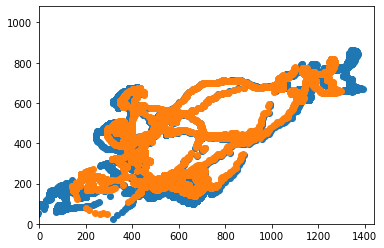

In [350]:
plt.scatter(x=centroids[:, 0], y=centroids[:, 1])
plt.scatter(x=dist_centroids[:, 0], y=dist_centroids[:, 1])
plt.xlim((0, 1440))
plt.ylim((0, 1080))

In [372]:
top_vids_info = analysis.find_src_videos(info, "top")

In [373]:
events = analysis.read_event_log(info)

In [374]:
es = events.query("event == 'loclearn/entered_area'")
ev_first = es.iloc[0]
ev_last = es.iloc[-1]
events = pd.DataFrame(data=[ev_first, ev_last])

In [375]:
vid_ev_df = analysis.create_video_event_df(top_vids_info, events)

In [376]:
vid_ev_df

path   frame  \
0  /data/reptilearn/experiments/pv20_after_yoloer...  600910   
1  /data/reptilearn/experiments/pv20_after_yoloer...  602198   

                      timestamp                   video_start  
0 2021-07-01 08:52:54.586266112 2021-07-01 05:53:35.059853824  
1 2021-07-01 08:53:17.620288000 2021-07-01 05:53:35.059853824

In [382]:
vid_path = list(top_vids_info.values())[0]["path"]

In [383]:
analysis.extract_clip(vid_path, vid_ev_df.iloc[0].frame - 3600, vid_ev_df.iloc[-1].frame + 3600, "../analysis/july1_consecutive_inout.mp4")

In [395]:
# add head bbox to this clip!

## Reinforced Area

In [150]:
ps = []

for info, cent_df in tqdm(zip(infos, cent_dfs), total=len(infos)):
    if info["session_state"] is not None and "reinforced_location" in info["session_state"]:
        state = info["session_state"]
        loc = state["reinforced_location"]
        
        if "params" in state and "reward_radius" in state["params"]:
            r2 = state["params"]["reward_radius"] ** 2
            dist2 = ((cent_df.values - loc) ** 2).sum(1)
            p = (dist2 < r2).sum() / len(cent_df)        
            ps.append(p)
        else:
            ps.append(None)
    else:
        ps.append(None)

  0%|          | 0/28 [00:00<?, ?it/s]

In [151]:
names = [r.dir.name for l, r in pv20.iterrows()]
list(zip(names, ps))

[('pv20_exp3_20210519_103530', None),
 ('pv20_exp3_20210519_120403', None),
 ('pv20_exp3_20210519_125353', None),
 ('pv20_exp3_20210519_133447', None),
 ('pv20_exp4_20210520_112511', None),
 ('pv20_exp6_20210524_092130', None),
 ('pv20_exp6_20210524_114758', None),
 ('pv20_exp7_20210527_111256', None),
 ('pv20_exp6_2_20210527_134505', None),
 ('pv20_exp8_20210531_101857', None),
 ('pv20_exp9_20210531_120417', None),
 ('pv20_exp10_bottom_left_20210602_110241', None),
 ('pv20_exp10_20210607_102406', None),
 ('pv20_exp11_20210610_105209', None),
 ('pv20_exp11_20210614_110403', None),
 ('pv20_long_20210630_114712', 0.002151494100775295),
 ('pv20_morning_20210701_070140', 0.0038334453147290818),
 ('pv20_morning_chg_stay_dur_20210701_080645', 0.0),
 ('pv20_after_cam_err_20210701_085145', 0.0),
 ('pv20_after_yoloerr_20210701_085333', 0.0013715937728000088),
 ('pv20_fixcd_20210701_123203', 0.0),
 ('pv20_20210707_103042', 0.007879540293628936),
 ('pv20_20210714_134525', 0.08689081979599547),
 (

In [22]:
list(zip(ps[-13:], names[-13:]))

[(0.002151494100775295, 'pv20_long_20210630_114712'),
 (0.0038334453147290818, 'pv20_morning_20210701_070140'),
 (0.0, 'pv20_morning_chg_stay_dur_20210701_080645'),
 (0.0, 'pv20_after_cam_err_20210701_085145'),
 (0.0013715937728000088, 'pv20_after_yoloerr_20210701_085333'),
 (0.0, 'pv20_fixcd_20210701_123203'),
 (0.007879540293628936, 'pv20_20210707_103042'),
 (0.08689081979599547, 'pv20_20210714_134525'),
 (0.06994902817453649, 'pv20_20210714_140216'),
 (0.14551952406816657, 'pv20_20210715_073038'),
 (0.07261836354455066, 'pv20_20210719_120954'),
 (0.13344870769123734, 'pv20_noaruco_20210721_103144'),
 (0.050992955061344776, 'pv20_top_right_20210726_095317')]

In [323]:
ax = sns.barplot(data=[None] + ps[-13:], orient="h", color='blue')
ax.set_title("Reinforced area visit probability")
ax.set_yticklabels([None] + names[-13:])
ax.set_xlabel("probability")
# normalize by movement?
# remove by speed threshold?

NameError: name 'ps' is not defined

# Timeline

In [19]:
def compute_zigzagity(seq_data):
    """
    :param seq_data: 3D sequence array
    :return: mean "Zigzagity", which is the angle difference between consecutive velocity vectors in the sequence
    """
    vecs = seq_data[:, 1:] - seq_data[:, :-1]
    u = vecs[:, 1:]
    v = vecs[:, :-1]
    u_norm = np.linalg.norm(u, axis=2)
    v_norm = np.linalg.norm(v, axis=2)
    dotprods = np.einsum(
        "ij,ij->i", u.reshape(-1, u.shape[2]), v.reshape(-1, v.shape[2])
    ).reshape(u.shape[0], u.shape[1])
    angles = np.arccos(dotprods / (u_norm * v_norm))
    return angles.mean(axis=1)


def mask_zgzg(min_zgzg, max_zgzg, by_X=True, by_Y=True):
    def f(X, Y):
        zgzgs_X = compute_zigzagity(X[:, :, :2])
        zgzgs_Y = compute_zigzagity(Y[:, :, :2])

        ret_mask = np.array([True] * X.shape[0])

        if by_X:
            ret_mask = ret_mask & ((zgzgs_X > min_zgzg) & (zgzgs_X < max_zgzg))
        if by_Y:
            ret_mask = ret_mask & ((zgzgs_Y > min_zgzg) & (zgzgs_Y < max_zgzg))
        return ret_mask

    return f

In [20]:
def sliding_window(
    df,
    col_labels,
    seq_size,
    keep_nans=False,
    mask_fn=None,
):
    """
    :param df: dataframe with the trial's detections
    :param labels: list of str, features to be used in the input sequence (xyxy for example)
    :param seq_size: int, length of the X sequence
    :param keep_nans: bool, whether to keep sequences with NaN
    :param mask_fn: boolean bask function, to filter data before creating the tensor
    :return: tuple X, 3D tensors of sequences
    """

    arrays_2d = []
    inds_range = df.shape[0] - seq_size + 1
    data = df[col_labels].values

    for i in range(inds_range):
        seq = data[i : i + seq_size]

        if (not keep_nans) and np.any(np.isnan(seq)):
            continue

        arrays_2d.append(seq)

    if len(arrays_2d) == 0:
        return None, None
    
    X = np.stack(arrays_2d)

    if mask_fn is not None:
        mask = mask_fn(X)
        X = X[mask]

    return X

In [21]:
def kleinberg_to_idxs(intervals, n, hierarchy=1):
    arr = np.zeros(n, dtype=bool)
    for interval in intervals:
        if interval[0] == hierarchy:
            for i in range(interval[1], interval[2]):
                if i < len(arr):
                    arr[i] = True
    return arr

In [111]:
def tag_motion(session_info, 
               cent_df,
               max_slow_speed=2, 
               min_slow_Z=1.7, 
               kleinberg_s=2,
               kleinberg_gamma=1,
               Z_win_size=100):
    
    if "head_bbox" not in session_info:
        raise Exception("Bounding box data was not found.")
            
    cent_vals = cent_df[["x", "y"]].values
    
    diffs = cent_df.diff()[["x", "y"]].values
    speeds = np.linalg.norm(diffs, axis=1)
    seqs = sliding_window(cent_df, ["x", "y"], Z_win_size, keep_nans=True)
    Z = compute_zigzagity(seqs)

    fast_cents = (speeds[:-Z_win_size+1] > max_slow_speed) & ((Z < min_slow_Z) | np.isnan(Z))
    offsets = cent_df[:-Z_win_size+1][fast_cents].index.values
    if len(offsets) > 0:
        fast_intervals = Kleinberg_burst_analysis.kleinberg(offsets, s=kleinberg_s, gamma=kleinberg_gamma)
    else:
        fast_intervals = []
        
    return fast_intervals, speeds, Z, fast_cents


In [86]:
def intervals_to_segments(intervals, cent_df, hierarchy=1):    
    slow_segments = []
    fast_segments = []
    
    last_end = 0
    
    fast_intervals = list(filter(lambda i: i[0] == hierarchy, intervals))
    print(fast_intervals)
    for i, (_, start, end) in enumerate(fast_intervals):
        slow_segments.append(cent_df.iloc[last_end : start])
        fast_segments.append(cent_df.iloc[start : end])
        last_end = end
        
    slow_segments.append(cent_df.iloc[last_end:])

    return slow_segments, fast_segments

In [90]:
def index_for_ts(df, ts):
    return abs(df.time-ts).idxmin()

In [87]:
def plot_stations(slow_segments, fast_segments, fps=1000/17, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    
    imgs = [p for p in info["images"] if "reinforced_area" in p.name]
    if len(imgs) > 0:
        img = cv.imread(str(imgs[0]))
        ax.imshow(img)
        
    for i, seg in enumerate(slow_segments):
        sd = np.nanstd(seg[["x", "y"]].values, axis=0)
        mean = np.nanmean(seg[["x", "y"]].values, axis=0)

        r = sum(sd)
        c = mean
        print(c, r)
        ax.add_patch(plt.Circle(c, r, color='orange', alpha=0.8, zorder=2))
        ax.text(c[0], c[1], f"{i}|{len(seg)//fps}s", c='r')
        ax.scatter(seg.x, seg.y, s=10, alpha=0.5, marker='>', color='blue')
    
    for seg in fast_segments:
        ax.plot(seg.x, seg.y, c='green')
        
    ax.axes.set_aspect('equal')
    ax.set_xlim(0, 1440)
    ax.set_ylim(0, 1080)
    ax.invert_yaxis()    
    

In [126]:
#sess_idx = -3
sess_idx = -1

info = infos[sess_idx]
centroids = analysis.get_head_centroids(info, None)
cent_df = pd.DataFrame(centroids, columns=["x", "y"])

bboxes = pd.read_csv(info["head_bbox"])
bboxes.time = pd.to_datetime(bboxes.time, unit="s") 

events = analysis.read_event_log(info)
reward_events = events[events.event == 'arena/dispense_reward']

In [127]:
reward_events

time                  event value
6   2021-08-09 08:28:12.127165952  arena/dispense_reward   NaN
10  2021-08-09 08:41:04.155599104  arena/dispense_reward   NaN
14  2021-08-09 09:05:22.936308992  arena/dispense_reward   NaN
23  2021-08-09 09:22:21.675627264  arena/dispense_reward   NaN
72  2021-08-09 09:31:30.263727616  arena/dispense_reward   NaN
78  2021-08-09 09:44:17.303933696  arena/dispense_reward   NaN
86  2021-08-09 09:53:39.343010304  arena/dispense_reward   NaN
192 2021-08-09 09:58:50.412971008  arena/dispense_reward   NaN
198 2021-08-09 10:11:58.489029120  arena/dispense_reward   NaN
202 2021-08-09 10:21:08.352150016  arena/dispense_reward   NaN
226 2021-08-09 10:29:19.378750464  arena/dispense_reward   NaN
232 2021-08-09 10:38:29.257761024  arena/dispense_reward   NaN
236 2021-08-09 10:38:42.221033728  arena/dispense_reward   NaN

In [128]:
%matplotlib widget

n = len(reward_events)-1
hierarchy=1
fig, axs = plt.subplots(n, 1, figsize=(8, 6*n))

for i, ax in zip(range(n), axs.flatten()):
    start = index_for_ts(bboxes, reward_events.time.values[i])
    end = index_for_ts(bboxes, reward_events.time.values[i+1])
    if end-start < 10:
        continue
    partial_cents =  cent_df.iloc[start:end].reset_index()
    print(i, start, end, '\n', '==============')
    intervals, speeds, Z, fast_cents = tag_motion(infos[sess_idx], partial_cents, min_slow_Z=1.8, max_slow_speed=3)
    """
    ax.plot(speeds, c="orange", zorder=1, alpha=0.5)
    twinax = ax.twinx()
    twinax.plot(Z, c="green", zorder=1, alpha=0.5)
    ax.scatter(np.arange(len(speeds[:-100+1])), fast_cents.astype(float) * np.nanmax(speeds), s=1, zorder=2)

    """
    """
    fast_frames = kleinberg_to_idxs(intervals, len(partial_cents), hierarchy)
    idxs = np.where(fast_frames)[0]
    ax.plot(speeds, zorder=-1)
    ax.scatter(x=idxs, y=np.ones(len(idxs)), s=1, c="r")
    twinax = ax.twinx()
    twinax.plot(Z, c="g", alpha=0.5)    
    """
    
    slow_segments, fast_segments = intervals_to_segments(intervals, partial_cents, hierarchy=hierarchy)
    plot_stations(slow_segments, fast_segments, ax=ax)
    
fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0 18972 62162 


  0%|          | 0/1192 [00:00<?, ?it/s]

[array([1, 100, 142], dtype=object), array([1.0, 8835, 8926], dtype=object), array([1.0, 24259, 24328], dtype=object), array([1.0, 24856, 25061], dtype=object), array([1.0, 32159, 32632], dtype=object), array([1.0, 34794, 35495], dtype=object), array([1.0, 35855, 36069], dtype=object), array([1.0, 36849, 37175], dtype=object), array([1.0, 37884, 38072], dtype=object), array([1.0, 38965, 40314], dtype=object), array([1.0, 40748, 41108], dtype=object), array([1.0, 42019, 42710], dtype=object)]
[1040.14258789  232.85792572] 1.1603110343482754
[428.18352612 253.96933154] 24.392116508954754
[421.31256333 270.73509699] 33.86008768114291
[622.34077708 329.04631181] 15.933607060376891
[421.39726541 289.19307137] 154.31399604313518
[464.837544   504.72882604] 28.047568001156474
[1166.16910052  622.34661691] 9.319088385791614
[1193.21132863  597.6631049 ] 12.923918122644952
[917.67292758 364.92749794] 10.548081148656932
[894.98909448 397.67714312] 6.215835502029103
[232.96371446 372.78932956] 16

  0%|          | 0/3188 [00:00<?, ?it/s]

[array([1.0, 72, 196], dtype=object), array([1.0, 2177, 2450], dtype=object), array([1.0, 26715, 27727], dtype=object), array([1.0, 35939, 36008], dtype=object), array([1.0, 37750, 37823], dtype=object), array([1.0, 38233, 38771], dtype=object), array([1.0, 40527, 48063], dtype=object), array([1.0, 48427, 48535], dtype=object), array([1.0, 49923, 52721], dtype=object), array([1.0, 58409, 58821], dtype=object), array([1.0, 61377, 61475], dtype=object), array([1.0, 63034, 63082], dtype=object), array([1.0, 64036, 64098], dtype=object), array([1.0, 72049, 72133], dtype=object), array([1.0, 73550, 73618], dtype=object), array([1.0, 75434, 75507], dtype=object), array([1.0, 77852, 77947], dtype=object), array([1.0, 79022, 79507], dtype=object), array([1.0, 81102, 81347], dtype=object)]
[1054.85844082  274.52894677] 1.744774356514823
[292.24460681 203.84514036] 27.672440071914842
[319.00338518 216.81388352] 29.6449387294279
[313.06244605 260.79248966] 22.936945831122642
[503.33256251 364.026

  0%|          | 0/55 [00:00<?, ?it/s]

[array([1, 91, 272], dtype=object)]
[1253.93398411  286.41199468] 1.1789935790532184
[471.39578995 139.87948961] 21.99804011647192
3 158374 189068 


  0%|          | 0/854 [00:00<?, ?it/s]

[array([1, 1, 58], dtype=object), array([1.0, 350, 458], dtype=object), array([1.0, 841, 1315], dtype=object), array([1.0, 3393, 4017], dtype=object), array([1.0, 4988, 5053], dtype=object), array([1.0, 16530, 17037], dtype=object), array([1.0, 20250, 21358], dtype=object), array([1.0, 22243, 22314], dtype=object), array([1.0, 25604, 26267], dtype=object), array([1.0, 26700, 26834], dtype=object), array([1.0, 27679, 27753], dtype=object), array([1.0, 28908, 29282], dtype=object), array([1.0, 29768, 29926], dtype=object), array([1.0, 30339, 30593], dtype=object)]
[531.23065186 439.25653076] 0.0
[449.46747767 301.89971506] 16.57646610105386
[400.11295573 231.74479562] 6.1661664649111865
[405.86445014 245.85551242] 17.439972832709817
[409.02476983 255.17820249] 1.9753485465365883
[409.35308274 233.35458525] 33.65893985545455
[412.98818886 222.29361624] 35.3279749659639
[247.1287251  201.19029631] 12.540449359704386
[417.89422091 351.72856799] 24.50273619118127
[222.53132876 431.6793191 ] 

  0%|          | 0/640 [00:00<?, ?it/s]

[array([1, 79, 307], dtype=object), array([1.0, 32979, 34028], dtype=object), array([1.0, 34959, 35012], dtype=object), array([1.0, 36980, 37836], dtype=object), array([1.0, 39611, 40951], dtype=object), array([1.0, 42066, 42706], dtype=object)]
[1205.02898166  357.43062659] 1.5301960370902954
[377.92796915 296.47208056] 103.69249415929059
[426.42591809 413.31043102] 17.756998692228496
[601.5003809  383.16159552] 26.223150472454382
[1301.98445945  642.42686283] 7.731210384771368
[1377.40224579  509.48487638] 34.19688741791337
[1200.47201006  230.30142134] 17.09619610529147
5 232011 263449 


  0%|          | 0/1440 [00:00<?, ?it/s]

[array([1, 71, 251], dtype=object), array([1.0, 12935, 13596], dtype=object), array([1.0, 21320, 21445], dtype=object), array([1.0, 21924, 22001], dtype=object), array([1.0, 23597, 23761], dtype=object), array([1.0, 24407, 24815], dtype=object), array([1.0, 25252, 25655], dtype=object), array([1.0, 26246, 26340], dtype=object), array([1.0, 26706, 26776], dtype=object), array([1.0, 27357, 27898], dtype=object), array([1.0, 28206, 28676], dtype=object), array([1.0, 29105, 29220], dtype=object), array([1.0, 29722, 30008], dtype=object), array([1.0, 30491, 31336], dtype=object)]
[1199.22676304  240.38768202] 3.177550429879158
[426.13387644 240.66171302] 32.28087126048662
[495.54713412 302.96739023] 128.72482629967243
[1181.37851459  501.53512346] 11.577552767450323
[1187.87192245  449.09567641] 28.922227725767243
[760.29776691 236.37685572] 16.45014876112883
[355.9799123 563.5606093] 17.07838607544526
[858.8753433  692.86080869] 18.68726480108003
[868.41410129 681.30977382] 17.126555776829

  0%|          | 0/1338 [00:00<?, ?it/s]

[array([1.0, 33, 95], dtype=object), array([1.0, 372, 412], dtype=object), array([1.0, 2139, 2346], dtype=object), array([1.0, 2589, 2792], dtype=object), array([1.0, 3957, 4010], dtype=object), array([1.0, 4869, 4984], dtype=object), array([1.0, 5762, 5820], dtype=object), array([1.0, 8536, 8656], dtype=object), array([1.0, 9032, 9072], dtype=object), array([1.0, 10270, 10490], dtype=object), array([1.0, 10707, 10763], dtype=object), array([1.0, 11429, 11573], dtype=object), array([1.0, 11802, 11872], dtype=object), array([1.0, 13822, 13885], dtype=object), array([1.0, 14723, 14861], dtype=object), array([1.0, 15224, 15409], dtype=object), array([1.0, 15578, 15669], dtype=object), array([1.0, 16217, 16505], dtype=object), array([1.0, 16917, 17089], dtype=object)]
[1041.26905037  174.4511728 ] 1.7727244742086343
[648.54184898 148.90805093] 101.08212104376028
[406.24914263 294.52099551] 70.09546565353686
[450.96433512 452.75558961] 12.5847065248693
[310.21279831 281.61525249] 115.574096

  0%|          | 0/1862 [00:00<?, ?it/s]

[array([1, 78, 123], dtype=object), array([1.0, 318, 603], dtype=object), array([1.0, 2851, 3143], dtype=object), array([1.0, 3620, 4102], dtype=object), array([1.0, 5785, 6096], dtype=object), array([1.0, 11799, 13679], dtype=object), array([1.0, 14040, 14198], dtype=object), array([1.0, 19547, 20791], dtype=object), array([1.0, 21272, 21531], dtype=object), array([1.0, 21865, 21934], dtype=object), array([1.0, 29305, 30155], dtype=object), array([1.0, 34596, 36649], dtype=object), array([1.0, 39313, 39326], dtype=object), array([1.0, 40217, 40308], dtype=object), array([1.0, 42082, 42177], dtype=object), array([1.0, 42706, 42753], dtype=object), array([1.0, 43493, 43757], dtype=object)]
[1271.85921556  127.58196165] 2.6486531160266056
[401.58243752 143.21722364] 80.92295769012892
[380.7950698  137.16952027] 16.451425305713034
[411.07201746 111.67619182] 3.3772157727017946
[406.51591227 112.4417869 ] 7.5284420722264445
[407.87450699 138.64265547] 28.739097458042586
[408.7641983  109.6

  0%|          | 0/453 [00:00<?, ?it/s]

[array([1, 2, 575], dtype=object), array([1.0, 1202, 1251], dtype=object), array([1.0, 20771, 21539], dtype=object), array([1.0, 22734, 23284], dtype=object), array([1.0, 29808, 30422], dtype=object)]
[1257.84967041  140.4642868 ] 0.8850936889648438
[413.95508096 117.57345015] 4.282067720620402
[404.00376784 256.73521774] 91.79993098477468
[286.00154846 364.03341867] 34.79158839333649
[718.54197314 455.52653183] 27.075773286033968
[1225.97404004  368.1307554 ] 12.162929432578597
9 355520 382954 


  0%|          | 0/1187 [00:00<?, ?it/s]

[array([1.0, 79, 401], dtype=object), array([1.0, 2123, 3181], dtype=object), array([1.0, 9830, 11432], dtype=object), array([1.0, 12341, 12510], dtype=object), array([1.0, 12802, 13109], dtype=object), array([1.0, 14190, 14398], dtype=object), array([1.0, 16389, 16592], dtype=object), array([1.0, 19161, 19230], dtype=object), array([1.0, 20470, 20857], dtype=object), array([1.0, 22033, 23330], dtype=object), array([1.0, 23993, 24398], dtype=object)]
[1224.18758344  364.24272561] 1.439205718811986
[324.27678617 270.19715061] 18.241208422941344
[272.33443972 272.69705809] 70.56198985331751
[246.90362373 287.95735301] 29.40449265799387
[539.82770006 515.96251456] 7.6321351020802135
[538.83278633 515.51799896] 4.703375329047052
[536.36921877 502.6228069 ] 10.692825979791102
[629.53965884 512.9957105 ] 104.46799439656999
[971.54999513 507.24187888] 55.65105159593679
[1290.52411596  510.17966839] 53.565317712653325
[1241.40977681  381.54040027] 10.258523415214551
[1197.59063771  379.5061330

  0%|          | 0/1081 [00:00<?, ?it/s]

[array([1.0, 6419, 7176], dtype=object), array([1.0, 11498, 12593], dtype=object), array([1.0, 13418, 13496], dtype=object), array([1.0, 13798, 14185], dtype=object), array([1.0, 14473, 14561], dtype=object), array([1.0, 15145, 15539], dtype=object), array([1.0, 15795, 16011], dtype=object), array([1.0, 17051, 17931], dtype=object), array([1.0, 23057, 23087], dtype=object), array([1.0, 23922, 24566], dtype=object), array([1.0, 28499, 28571], dtype=object), array([1.0, 30106, 30292], dtype=object)]
[1158.97900226  328.90578289] 41.600642664214476
[1123.98115188  286.22253121] 45.127600309109745
[776.04694841 390.22870773] 23.126644534611597
[685.23993647 586.53787373] 8.725233825570912
[520.43234657 666.88952041] 21.793701173182207
[448.39847195 649.25917195] 22.42603807587009
[555.96568108 801.51521516] 11.335173965811798
[702.16471086 822.09194703] 21.17474193175744
[875.37020404 465.16949501] 21.55564965764129
[952.52099741 421.99171526] 52.15551080871842
[1002.77224484  441.95567815

In [129]:
# Good params
#sess_idx = -2
#max_freeze_speed = 3
#min_freeze_Z = 1.7
#start_idx = 30000
#end_idx = 40000
#kleinberg_hierarchy = 1
#win_size = 100

sess_idx = -3
max_freeze_speed = 3
min_freeze_Z = 1.7
start_idx = reward_frames[3]
end_idx = reward_frames[4]
kleinberg_hierarchy = 1
win_size = 100

cent_df = cent_dfs[sess_idx].iloc[start_idx:end_idx][["x", "y"]].reset_index()
info = infos[sess_idx]
diffs = cent_df.diff().values
speeds = np.linalg.norm(diffs, axis=1)

seqs = sliding_window(cent_df, ["x", "y"], win_size, keep_nans=True)
Z = compute_zigzagity(seqs)

fast_cents = (speeds[:-win_size+1] > max_freeze_speed) & ((Z < min_freeze_Z) | np.isnan(Z))
offsets = cent_df[:-win_size+1][fast_cents].index.values

NameError: name 'reward_frames' is not defined

In [1019]:
import scipy.stats as stats
corr_df = pd.DataFrame(np.vstack((speeds[:-win_size+1], Z)).T, columns=["speed", "Z"]).dropna()
stats.pearsonr(corr_df.speed, corr_df.Z)

(-0.37663219682139715, 0.0)

In [1020]:
print(np.isnan(speeds).sum(), '/', len(speeds))

315 / 11420


In [1021]:
%matplotlib widget
fig, ax = plt.subplots()
ax.plot(speeds, c="orange", zorder=1, alpha=0.5)
twinax = ax.twinx()
twinax.plot(Z, c="green", zorder=1, alpha=0.5)
ax.scatter(np.arange(len(speeds[:-win_size+1])), fast_cents.astype(float) * np.nanmax(speeds), s=1, zorder=2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [1022]:
intervals = Kleinberg_burst_analysis.kleinberg(offsets, s=2, gamma=1)
print(len(list(filter(lambda i: i[0] == 1, intervals))), 'intervals')

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

7 intervals


In [978]:
fast_frames = kleinberg_to_idxs(intervals, len(cent_df), kleinberg_hierarchy)

idxs = np.where(fast_frames)[0]

In [979]:
%matplotlib widget
fig, ax = plt.subplots()
ax.plot(speeds, zorder=-1)
ax.scatter(x=idxs, y=np.ones(len(idxs)), s=1, c="r")
twinax = ax.twinx()
twinax.plot(Z, c="g", alpha=0.5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Plot foraging map

In [980]:
def station_stats(coords):
    return coords[["x", "y"]].mean(axis=0), coords[["x", "y"]].std(axis=0), coords

In [981]:
%matplotlib widget
fast_intervals = list(filter(lambda i: i[0] == kleinberg_hierarchy, intervals))
fig, ax = plt.subplots()
ax.imshow(backgrounds[sess_idx])
last_end = 0
for i, (_, start, end) in enumerate(fast_intervals):
    station_mean, station_sd, slow_coords = station_stats(cent_df.iloc[last_end: start])
    r = sum(station_sd)
    #r = 1000 * len(slow_coords) / len(cent_df)
    c = station_mean
    print(r, c)
    ax.add_patch(plt.Circle(c, r, color='orange', alpha=0.8, zorder=2))
    ax.text(c[0], c[1], f"{i}|{len(slow_coords)//60}s")
    ax.scatter(slow_coords.x, slow_coords.y, s=10, alpha=0.5, marker='>', color='blue')
    fast_coords = cent_df.iloc[start : end]
    ax.plot(fast_coords.x, fast_coords.y, c='green')
    last_end = end

station_mean, station_sd, slow_coords = station_stats(cent_df.iloc[last_end:])
r = sum(station_sd)
c = station_mean

ax.scatter(slow_coords.x, slow_coords.y, s=3, alpha=0.5, marker='>', color='blue')
ax.add_patch(plt.Circle(c, r, color='orange', alpha=0.8, zorder=2))
ax.text(c[0], c[1], f"{i+1}|{len(slow_coords)//60}s")
ax.axes.set_aspect('equal')
ax.set_xlim(0, 1440)
ax.set_ylim(0, 1080)
ax.invert_yaxis()



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

25.95165046365647 x    1062.184580
y     396.434353
dtype: float64
23.192702696475884 x    371.922025
y    434.107505
dtype: float64
12.447708517709296 x    307.156487
y    658.690405
dtype: float64
37.56901635604714 x    408.232691
y    829.985784
dtype: float64
14.028197082027605 x    816.407339
y    818.290321
dtype: float64
7.688385201792988 x    921.190101
y    649.301721
dtype: float64
46.71402207186932 x    753.405832
y    429.817229
dtype: float64


## Generate Video

In [ ]:
top_vids = analysis.find_src_videos(info, "top")
top = list(top_vids.values())

for vid in top:
    vid_path = vid["path"]
    pos_df = pd.read_csv(info["head_bbox"])
    bboxes = pos_df[["x1", "y1", "x2", "y2"]].to_numpy()

    visualize.process_video(vid_path, f"../analysis/{vid_path.stem}_loc_tag_Z.mp4", [
        visualize.offline_centroid_visualizer(bboxes, window_size=1),
        #visualize.offline_frame_marker(fast_frames, duration=10)
    ], start_frame=start_idx, num_frames=end_idx-start_idx, speed=5)

  0%|          | 0/2284 [00:00<?, ?it/s]

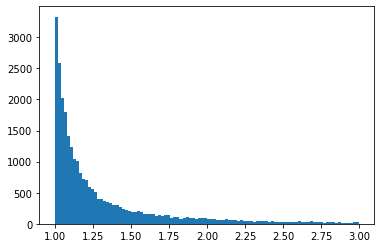

In [912]:
%matplotlib inline
plt.hist(speeds[speeds < max_freeze_speed], bins=100)
pass

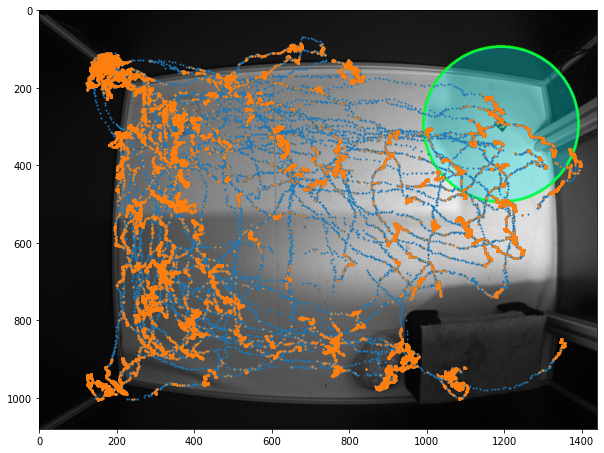

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(backgrounds[i], zorder=-2)
plt.scatter(x=centroids[:, 0], y=centroids[:, 1], s=1)
plt.scatter(x=slow_centroids[:, 0], y=slow_centroids[:, 1], s=1)
ax.axes.set_aspect('equal')
ax.set_xlim(0, 1440)
ax.set_ylim(0, 1080)
ax.invert_yaxis()

state = infos[i]["session_state"]
rloc = state["reinforced_location"]
r = state["params"]["reward_radius"]
ax.add_patch(plt.Circle(rloc, r, color='cyan', alpha=0.3, zorder=-1))
# try variable bin size. @slow mvmt, make time bins larger (use median for position in bins)
# circular color map to show heading at each point
# find targets of runs

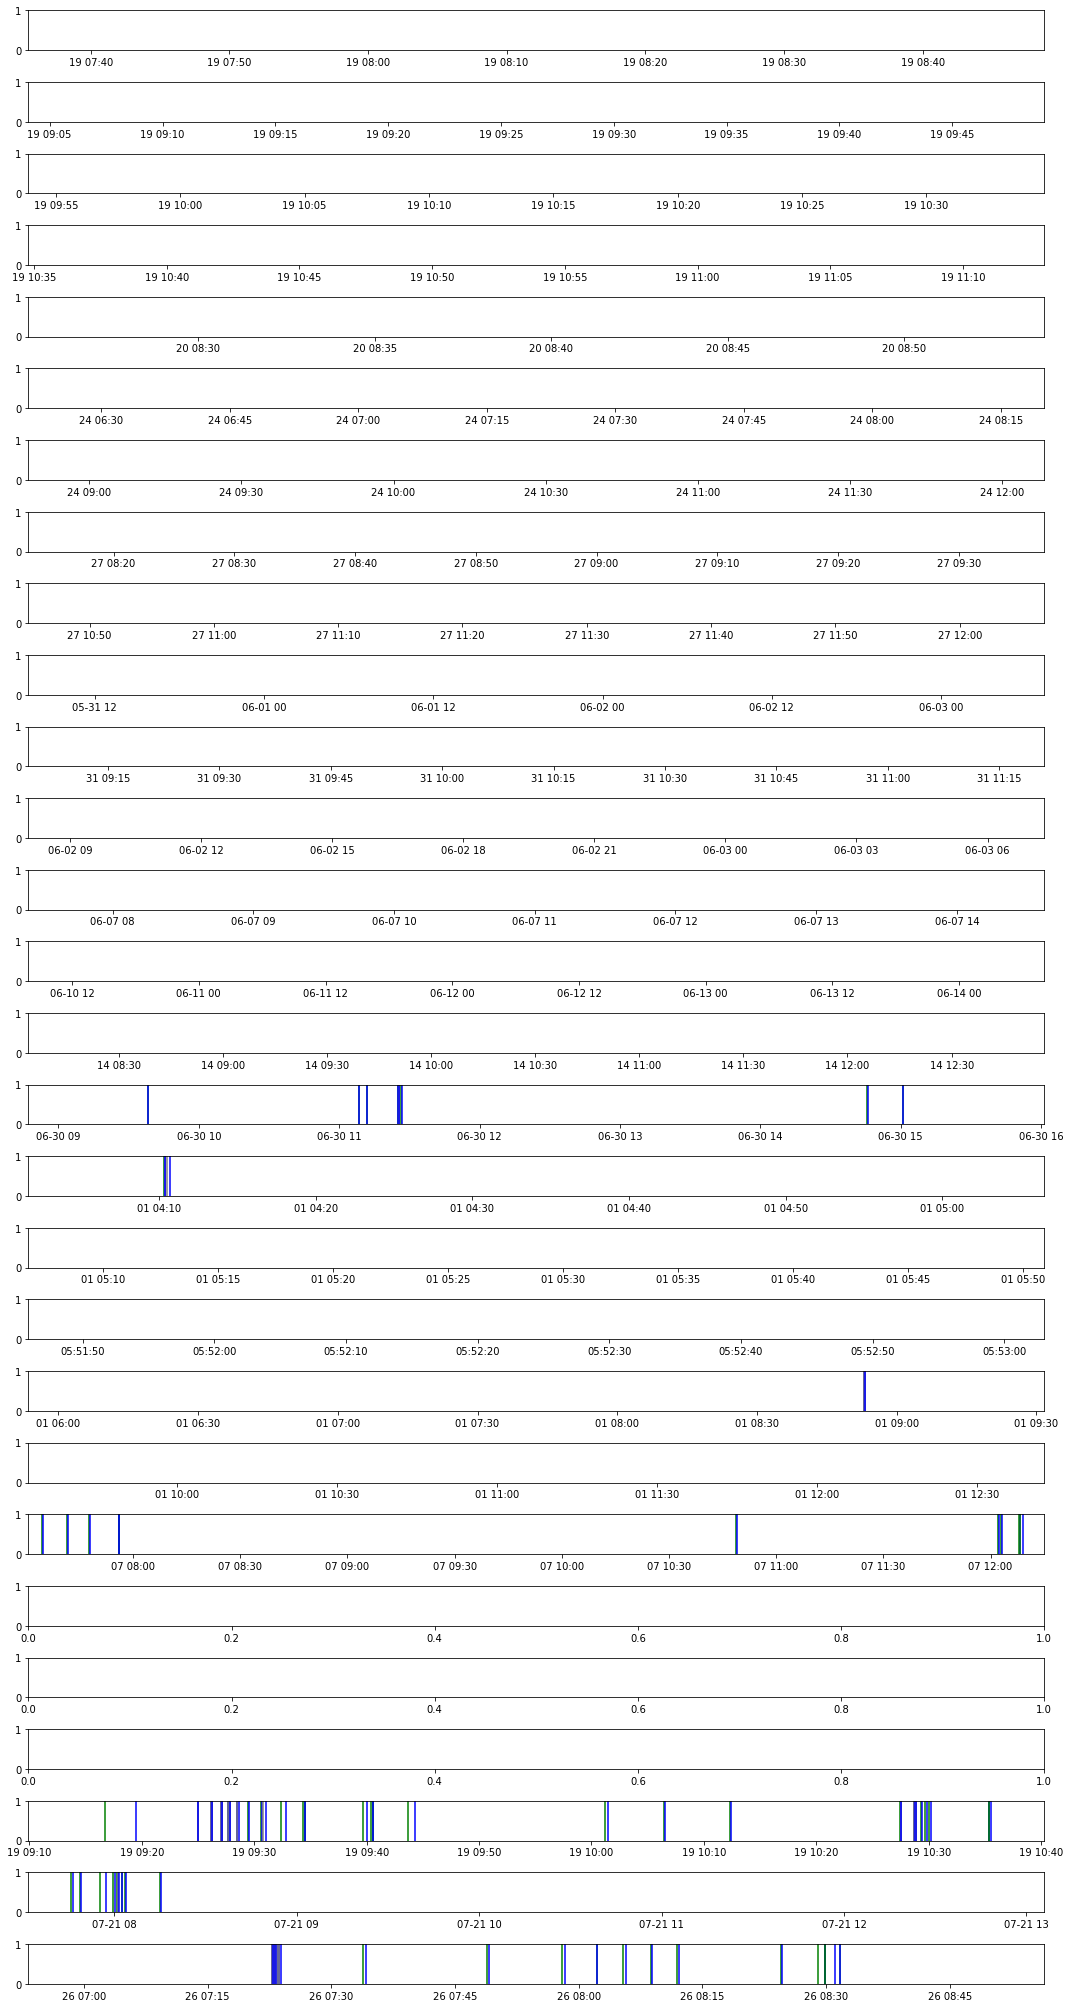

In [172]:
fig, axs = plt.subplots(len(infos), 1, figsize=(15, len(infos)))
for i, ax in enumerate(axs):
    try:
        events = analysis.read_event_log(infos[i])
    
        ax.set_xlim(events.time.values[0], events.time.values[-1])

        for _, e in events.iterrows():
            if e.event == "loclearn/entered_area":
                if json.loads(e.value)["cooldown"]:
                    ax.axvline(e.time, c="gray")
                else:
                    ax.axvline(e.time, c="green")
            elif e.event == "loclearn/left_area":
                ax.axvline(e.time, c="blue")
    except Exception as e:
        continue

fig.tight_layout()

# Distance

In [187]:
dists = []

for info, cent_df in tqdm(zip(infos, cent_dfs), total=len(infos)):
    if info["session_state"] is not None and "reinforced_location" in info["session_state"]:
        state = info["session_state"]
        loc = state["reinforced_location"]

        if "params" in state and "reward_radius" in state["params"]:
            r2 = state["params"]["reward_radius"] ** 2
            dist = np.sqrt(((cent_df.values - loc) ** 2).sum(1))
            dists.append(dist)
        else:
            dists.append(None)
    else:
        dists.append(None)
    

  0%|          | 0/26 [00:00<?, ?it/s]

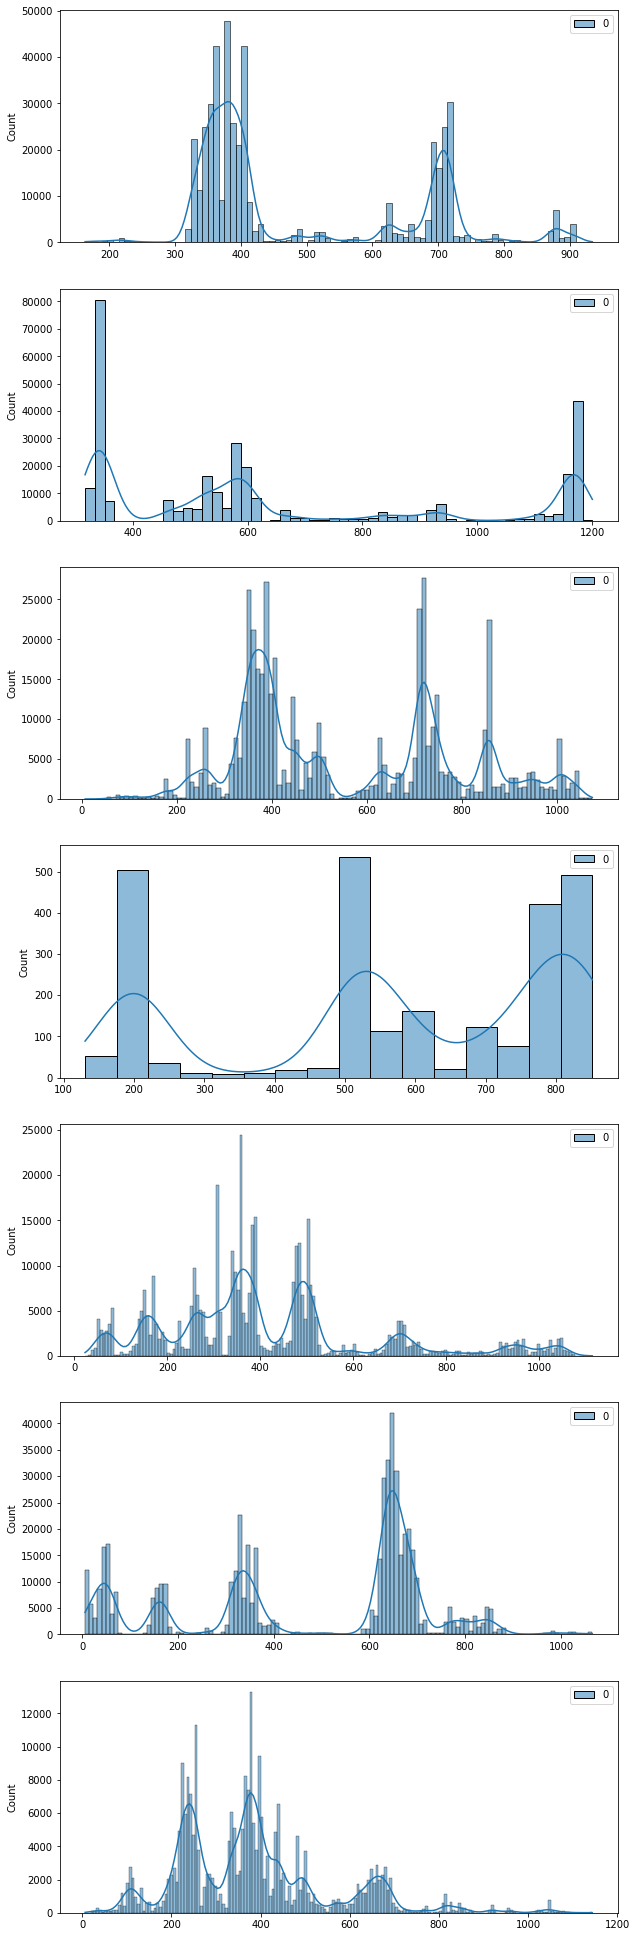

In [188]:
fig, axs = plt.subplots(nrows=7, figsize=(10,5*7))
for i, ax in enumerate(axs):
    dist_df = pd.DataFrame(dists[-7:][i])
    if int(dist_df.notna().sum()) > 0:
        sns.histplot(dist_df, ax=ax, kde=True)

In [147]:
session = -2
info = infos[session]
cent_df = cent_dfs[session]
enter_events = []
exit_events = []

loc = info["session_state"]["reinforced_location"]
r2 = state["params"]["reward_radius"] ** 2
dist2 = ((cent_df.values - loc) ** 2).sum(1)
in_area = dist2 < r2


In [149]:
np.argwhere(in_area == True)

array([[   330],
       [   331],
       [   332],
       ...,
       [733803],
       [733807],
       [733808]])

In [181]:
from moviepy.editor import VideoFileClip
import moviepy.video.fx.all as vfx

last = infos[-1]

In [182]:
top_infos = analysis.find_src_videos(last, "top")

In [186]:
for top_info in top_infos.values():
    clip = VideoFileClip(str(top_info["path"]))
final = clip.fx(vfx.speedx, 15)
final.write_videofile('../analysis/timelapse_pv20_20210719.mp4')

t:   0%|          | 5/19143 [00:00<09:04, 35.16it/s, now=None]

Moviepy - Building video ../analysis/timelapse_pv20_20210719.mp4.
Moviepy - Writing video ../analysis/timelapse_pv20_20210719.mp4



Moviepy - Done !
Moviepy - video ready ../analysis/timelapse_pv20_20210719.mp4


# Video playback timestamps

In [19]:
exp = exps[exps.name=="video_test"].iloc[0]
info = analysis.experiment_info(exp.dir)

In [20]:
info

{'videos': {},
 'csvs': [PosixPath('/data/reptilearn/experiments/video_test_20210724_143326/video_timestamps.csv')],
 'event_log': PosixPath('/data/reptilearn/experiments/video_test_20210724_143326/events.csv'),
 'images': [],
 'session_state': {'is_running': True,
  'experiment': 'video_test',
  'data_dir': '/data/reptilearn/experiments/video_test_20210724_143326',
  'id': 'video_test',
  'start_time': '2021-07-24T14:33:26.368220',
  'params': {'vid_path': '/data/amit/videos/headbobbing1.mp4',
   'background_color': 'black',
   'record_video': False},
  'blocks': [{}],
  'actions': [],
  'cur_block': 0,
  'cur_trial': 0}}

In [30]:
vts_path = info['csvs'][0]
vts_path = "/data/reptilearn/experiments/video_test_20210724_165223/video_timestamps.csv"

In [31]:
vtsdf = pd.read_csv(vts_path, index_col="frame")

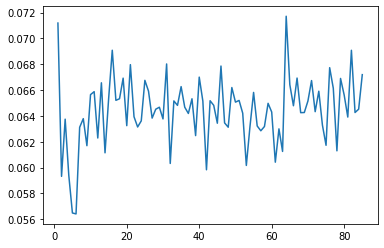

In [33]:
plt.plot(vtsdf.diff())

In [59]:
vtsdf = pd.read_csv("/data/reptilearn/experiments/video_test_20210724_180244/video_timestamps.csv", index_col="frame", parse_dates=True)

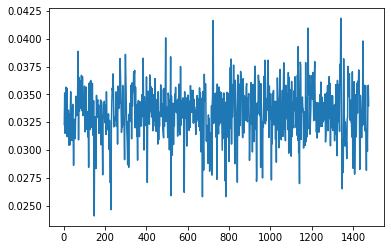

In [60]:
plt.plot(vtsdf.diff())

In [63]:
vtsdf.diff().mean(), vtsdf.diff().std()

(time    0.033253
 dtype: float64,
 time    0.002387
 dtype: float64)

In [49]:
vtsdf.time.values[-1] - vtsdf.time.values[0]

9.68247675895691

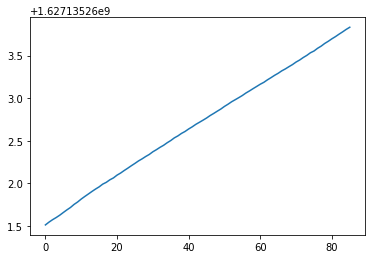

In [64]:
plt.plot(vstdf)

# Total distance travelled (path integral)

In [554]:
bin_width = 1 * 60 * 60 # in frames
all_diffs = []
sums = []
avgs = []
# note: cent_df might have more values than video frames in the session (this causes event frames to be misaligned)
for info, cent_df in tqdm(zip(infos, cent_dfs), total=len(infos)):
    for i in range(0, len(cent_df), bin_width):
        cent_seg = cent_df[i:min(i+bin_width,len(cent_df))]
        diffs = cent_seg.diff().values
        all_diffs.append(diffs)
        lens = np.nansum(np.sqrt(diffs ** 2), axis=1)
        sums.append(lens.sum())
        avgs.append(sums[-1] / len(cent_seg))

  0%|          | 0/29 [00:00<?, ?it/s]

In [555]:
def count_rewards(info, bin_width):
    
    vids = analysis.find_src_videos(info, "top")
    total_frames = sum([v["frame_count"] for v in vids.values()])
    num_bins = int(total_frames // bin_width) + 1
    bin_counts = [0] * num_bins

    try:
        events = analysis.read_event_log(info)
        rewards = events.query("event == 'arena/dispense_reward'")
    except Exception as e:
        print(e)
        return bin_counts
    
    for _, reward in rewards.iterrows():
        vid_pos_info = analysis.find_video_position(info, reward.time)
            
        if len(vid_pos_info) == 0:
            print("skipping reward:", reward)
            continue
        frame = vid_pos_info[0]["frame"]

        bin = frame // bin_width

        bin_counts[bin] += 1
    return bin_counts


In [558]:
%matplotlib widget

fig, ax = plt.subplots()
ax.plot(avgs, label="distance travelled")

counts = []
for info in infos:
    sess_counts = count_rewards(info, bin_width)
    if sess_counts is not None:
        counts += sess_counts

ax = ax.twinx()
ax.plot(np.array(counts), label="rewards", c="orange")
#ax.legend()



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

skipping reward: time     2021-05-31 09:08:22.389135616
event            arena/dispense_reward
value                              NaN
Name: 142, dtype: object
skipping reward: time     2021-05-31 09:30:54.763885568
event            arena/dispense_reward
value                              NaN
Name: 174, dtype: object
skipping reward: time     2021-05-31 09:46:37.361523456
event            arena/dispense_reward
value                              NaN
Name: 200, dtype: object
skipping reward: time     2021-05-31 10:39:32.516190208
event            arena/dispense_reward
value                              NaN
Name: 262, dtype: object
skipping reward: time     2021-05-31 11:19:34.782583808
event            arena/dispense_reward
value                              NaN
Name: 311, dtype: object
skipping reward: time     2021-06-02 11:03:21.274872832
event            arena/dispense_reward
value                              NaN
Name: 3161, dtype: object
skipping reward: time     2021-06-02 14:06:09

In [403]:
smaller = min(len(avgs), len(counts))
fig, ax = plt.subplots()
ax.scatter(avgs[:smaller], counts[:smaller])
stats.pearsonr(avgs[:smaller], counts[:smaller])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(0.08712984930089017, 2.6647357401357484e-11)

# Time bins

In [544]:
sess = sessions.iloc[-1]
info = infos[-1]
vids = analysis.find_src_videos(info, "top")
bin_width = 10*60  # seconds
vid_bins = []

In [545]:
for ts, vid_info in vids.items():
    vid_dur_secs = vid_info["duration"] / np.timedelta64(1, 's')
    bins = np.arange(0, vid_dur_secs, bin_width)
    bins = np.append(bins, bins[-1] + bin_width)
    vid_info["time_bins"] = pd.to_timedelta(bins, unit="s") + ts.tz_localize("Asia/Jerusalem").astimezone("utc")


In [546]:
pos_df = pd.read_csv(info["head_bbox"], index_col="time")
pos_df.index = pd.to_datetime(pos_df.index, unit="s")
pos_df.index = pos_df.index.tz_localize("utc")
bboxes = pos_df[["x1", "y1", "x2", "y2"]]
centroids = bbox.xyxy_to_centroid(bboxes.to_numpy()) 
pos_df[["cent_x", "cent_y"]] = centroids

In [547]:
bins = list(vids.values())[0]["time_bins"]

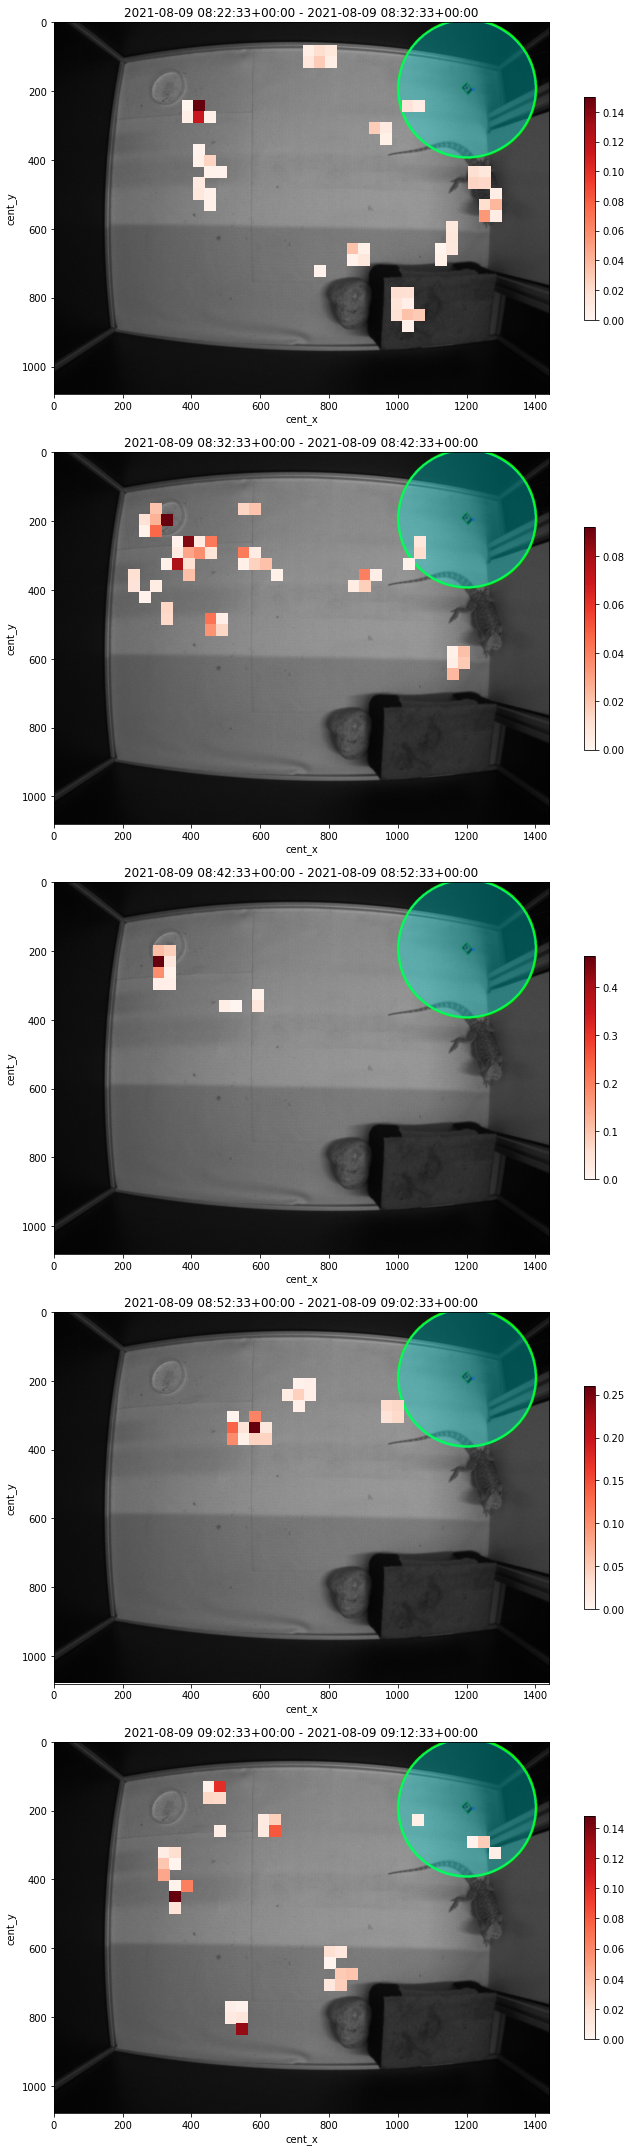

In [548]:
%matplotlib inline
n = len(bins)-1
sx = 10
sy = 6
fig, axs = plt.subplots(n, 1, figsize=(sx, sy*n))
axs = axs.flatten()

for i in range(n):
    pos_segment = pos_df[bins[i]: bins[i+1]]
    ax = axs[i]
    sns.histplot(pos_segment, x="cent_x", y="cent_y", cbar=True, stat="probability", cmap=sns.color_palette("Reds", as_cmap=True), ax=axs[i],
             cbar_kws={"shrink": 0.6}, binwidth=32, thresh=0.0014)

    if info["session_state"] and "reinforced_location" in info["session_state"]:                
        state = info["session_state"]
        rloc = state["reinforced_location"]
        
        if "params" in state and "reward_radius" in state["params"]:
            r = state["params"]["reward_radius"]
            ax.add_patch(plt.Circle(rloc, r, color='cyan', alpha=0.3, zorder=-1))
        else:
            ax.add_patch(plt.Circle(rloc, 10, color='magenta', alpha=0.3, zorder=-1))
            
    #ax.scatter(cent_df.x, cent_df.y, alpha=0.1, s=1)
    if backgrounds[-1] is not None:
        ax.imshow(backgrounds[-1], zorder=-2)

        
    ax.set_title(f"{bins[i]} - {bins[i+1]}")
    ax.axes.set_aspect('equal')
    ax.set_xlim(0, 1440)
    ax.set_ylim(0, 1080)
    ax.invert_yaxis()
    
fig.tight_layout()    

In [549]:
ps = []
start_idxs = [0]

for ts, vid_info in vids.items():
    bins = vid_info["time_bins"] 
    n = len(bins)-1
    start_idxs.append(start_idxs[-1] + n)
    
    for i in range(n):
        pos_segment = pos_df[bins[i]: bins[i+1]]
        state = info["session_state"]
        loc = state["reinforced_location"]
        r2 = state["params"]["reward_radius"] ** 2
        dist2 = ((pos_segment[["cent_x", "cent_y"]] - loc) ** 2).sum(1)
        p = (dist2 < r2).sum() / len(pos_segment)
        ps.append(p)        

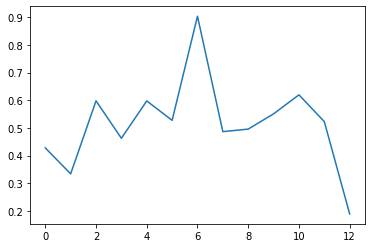

In [552]:
plt.plot(ps)

In [533]:
list(vids.values())[0]["duration"] / np.timedelta64(1, 'm')

34.28231035866666

# maybe remove last bin (short)